# DeepSphere using SHREC17 dataset
Projection of 3D objects on a unit sphere.
This sphere use a HEALpix sampling, and several features are collected:
* projection ray length
* cos/sin with surface normal
* same features using the convex hull

## 0 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import Shrec17DeepSphere as shrecDataset
from SHREC17.load_shrec import fix_dataset

# 0.2 Define parameters

In [5]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/'

In [6]:
sigma_noise = 0
noise_dataset = True
augmentation = 1    # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
fix = False
if fix:
    fix_dataset(datapath+'test_perturbed')

In [8]:
download = False
train_dataset = shrecDataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)


31363it [00:27, 1129.37it/s]


## 1.1 Preprocess the dataset

In [9]:
x_train, labels_train, x_val, labels_val, ids_train, ids_val = train_dataset.return_data(train=True)

Number of elements / class
  Training set: 
    Class 0: 1982 elements
    Class 1: 160 elements
    Class 2: 42 elements
    Class 3: 55 elements
    Class 4: 423 elements
    Class 5: 126 elements
    Class 6: 889 elements
    Class 7: 38 elements
    Class 8: 200 elements
    Class 9: 234 elements
    Class 10: 82 elements
    Class 11: 452 elements
    Class 12: 758 elements
    Class 13: 53 elements
    Class 14: 53 elements
    Class 15: 26 elements
    Class 16: 1744 elements
    Class 17: 257 elements
    Class 18: 3235 elements
    Class 19: 330 elements
    Class 20: 37 elements
    Class 21: 45 elements
    Class 22: 518 elements
    Class 23: 33 elements
    Class 24: 368 elements
    Class 25: 150 elements
    Class 26: 388 elements
    Class 27: 77 elements
    Class 28: 268 elements
    Class 29: 193 elements
    Class 30: 1131 elements
    Class 31: 227 elements
    Class 32: 793 elements
    Class 33: 50 elements
    Class 34: 34 elements
    Class 35: 70 elements
    

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31363 
first id: 014658


#### Plot sphere images

In [11]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = min(np.min(im1), np.min(im0003))
cmax = max(np.max(im1), np.max(im0003))

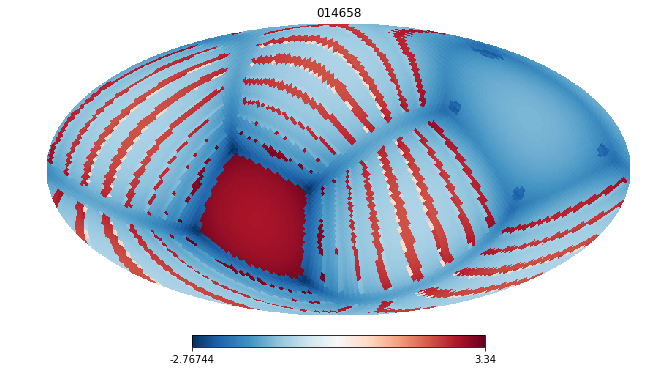

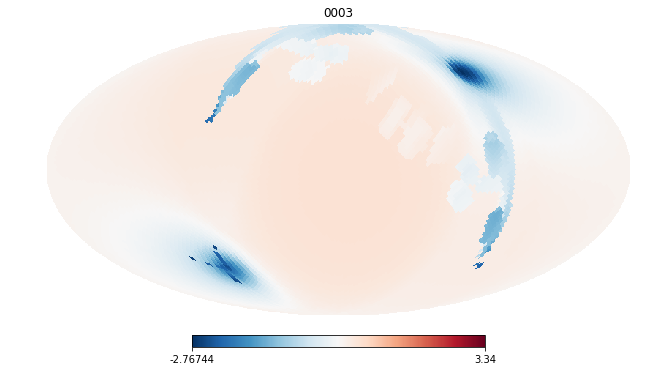

In [12]:
hp.mollview(im1, title=ids_train[0], nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(im0003, title='00003', nest=True, cmap=cm, min=cmin, max=cmax)

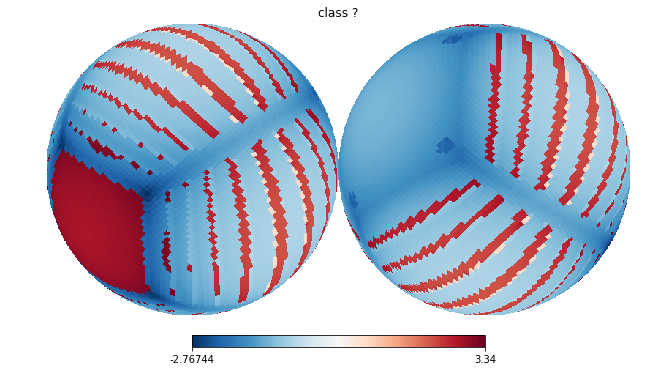

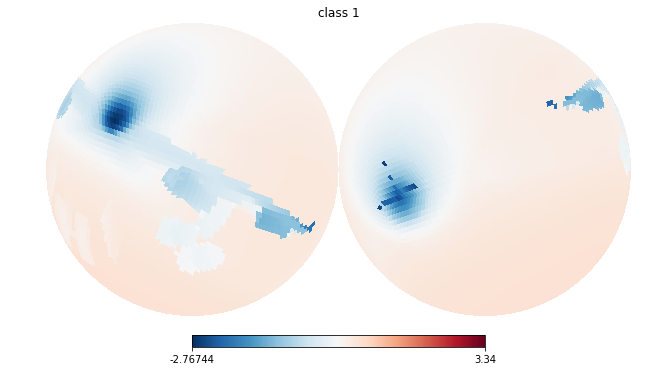

In [13]:
hp.orthview(im1, title='014658', nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003, xsize=12*32**2, rot=(90,90,290), title='00003', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)

## 2 Classification using DeepSphere

In [14]:
training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
validation = LabeledDataset(x_val, labels_val)

In [15]:
EXP_NAME = 'shrec17_Cohen_simple_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)

In [17]:
params = hyperparameters.get_params_shrec17(training.N, EXP_NAME, Nside, train_dataset.nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4, 4]
#pixels: [12288, 768, 192, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 9,249,177,600
Learning rate will start at 2.0e-02 and finish at 1.8e-04.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 1 * 100 * 5 = 500
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 5 = 50000
    biases: F_2 = 100
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 192 * 55 / 1 = 10560
    weights: F_2 * F_3 * K_3 = 100 * 55 * 5 = 27500
    biases: F_3 = 55
    batch normalization
  layer 4: logits (softmax)
    representation: M_4 = 55
    weights: M_3 * M_4 = 10560 * 55 = 580800


In [18]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: fc1
    representation: M_4 = 64
    weights: M_3 * M_4 = 12288 * 64 = 786432
    biases: M_4 = 64
  layer 5: logits (softmax)
    representation: M_5 = 55
    weights: M_4 * M_5 = 64 * 55 = 3520
step 39 / 15681 (epoch 0.05 / 20):
  learning_rate = 1.06e-06, training loss = 4.19e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 4.89 (307 / 6273), f1 (weighted): 5.03, loss: 4.33e+00
  CPU time: 29s, wall time: 28s
step 78 / 15681 (epoch 0.10 / 20):
  learning_rate = 1.12e-06, training loss = 3.98e+00
  validation accuracy: 12.47 (782 / 6273), f1 (weighted): 7.80, loss: 4.15e+00
  CPU time: 49s, wall time: 48s
step 117 / 15681 (epoch 0.15 / 20):
  learning_rate = 1.19e-06, training loss = 4.41e+00
  validation accuracy: 16.01 (1004 / 6273), f1 (weighted): 7.20, loss: 4.01e+00
  CPU time: 67s, wall time: 65s
step 156 / 15681 (epoch 0.20 / 20):
  learning_rate = 1.26e-06, training loss = 3.97e+00
  validation accuracy: 16.40 (1029 / 6273), f1 (weighted): 6.67, loss: 3.91e+00
  CPU time: 85s, wall time: 83s
step 195 / 15681 (epoch 0.25 / 20):
  learning_rate = 1.33e-06, training loss = 3.93e+00
  validation accuracy: 16.36 (1026 / 6273), f1 (weighted): 6.12, loss: 3.84e+00
  CPU time: 103s, wall time: 100s
step 234 / 15681 (epoch 0.30 / 20):
  learning_rate = 1.41e-06, training loss = 4.38e+

step 1638 / 15681 (epoch 2.09 / 20):
  learning_rate = 1.11e-05, training loss = 2.17e+00
  validation accuracy: 50.57 (3172 / 6273), f1 (weighted): 42.68, loss: 2.39e+00
  CPU time: 767s, wall time: 741s
step 1677 / 15681 (epoch 2.14 / 20):
  learning_rate = 1.17e-05, training loss = 2.68e+00
  validation accuracy: 50.41 (3162 / 6273), f1 (weighted): 42.42, loss: 2.37e+00
  CPU time: 785s, wall time: 758s
step 1716 / 15681 (epoch 2.19 / 20):
  learning_rate = 1.24e-05, training loss = 2.48e+00
  validation accuracy: 52.05 (3265 / 6273), f1 (weighted): 44.01, loss: 2.33e+00
  CPU time: 804s, wall time: 776s
step 1755 / 15681 (epoch 2.24 / 20):
  learning_rate = 1.31e-05, training loss = 2.64e+00
  validation accuracy: 52.67 (3304 / 6273), f1 (weighted): 45.51, loss: 2.30e+00
  CPU time: 822s, wall time: 793s
step 1794 / 15681 (epoch 2.29 / 20):
  learning_rate = 1.39e-05, training loss = 2.37e+00
  validation accuracy: 52.40 (3287 / 6273), f1 (weighted): 44.62, loss: 2.28e+00
  CPU tim

step 3198 / 15681 (epoch 4.08 / 20):
  learning_rate = 1.09e-04, training loss = 1.74e+00
  validation accuracy: 61.12 (3834 / 6273), f1 (weighted): 57.30, loss: 1.79e+00
  CPU time: 1488s, wall time: 1437s
step 3237 / 15681 (epoch 4.13 / 20):
  learning_rate = 1.16e-04, training loss = 1.59e+00
  validation accuracy: 60.48 (3794 / 6273), f1 (weighted): 55.63, loss: 1.84e+00
  CPU time: 1506s, wall time: 1454s
step 3276 / 15681 (epoch 4.18 / 20):
  learning_rate = 1.23e-04, training loss = 1.32e+00
  validation accuracy: 59.45 (3729 / 6273), f1 (weighted): 55.93, loss: 1.82e+00
  CPU time: 1524s, wall time: 1472s
step 3315 / 15681 (epoch 4.23 / 20):
  learning_rate = 1.30e-04, training loss = 1.84e+00
  validation accuracy: 60.43 (3791 / 6273), f1 (weighted): 57.21, loss: 1.80e+00
  CPU time: 1542s, wall time: 1489s
step 3354 / 15681 (epoch 4.28 / 20):
  learning_rate = 1.38e-04, training loss = 1.33e+00
  validation accuracy: 60.64 (3804 / 6273), f1 (weighted): 56.91, loss: 1.82e+00
 

step 4758 / 15681 (epoch 6.07 / 20):
  learning_rate = 1.08e-03, training loss = 1.52e+00
  validation accuracy: 64.36 (4037 / 6273), f1 (weighted): 60.36, loss: 1.88e+00
  CPU time: 2208s, wall time: 2131s
step 4797 / 15681 (epoch 6.12 / 20):
  learning_rate = 1.14e-03, training loss = 2.07e+00
  validation accuracy: 59.00 (3701 / 6273), f1 (weighted): 55.80, loss: 2.03e+00
  CPU time: 2225s, wall time: 2148s
step 4836 / 15681 (epoch 6.17 / 20):
  learning_rate = 1.21e-03, training loss = 2.50e+00
  validation accuracy: 63.30 (3971 / 6273), f1 (weighted): 59.74, loss: 1.92e+00
  CPU time: 2243s, wall time: 2166s
step 4875 / 15681 (epoch 6.22 / 20):
  learning_rate = 1.28e-03, training loss = 1.73e+00
  validation accuracy: 60.90 (3820 / 6273), f1 (weighted): 59.43, loss: 2.03e+00
  CPU time: 2261s, wall time: 2183s
step 4914 / 15681 (epoch 6.27 / 20):
  learning_rate = 1.36e-03, training loss = 2.04e+00
  validation accuracy: 59.03 (3703 / 6273), f1 (weighted): 57.28, loss: 2.17e+00
 

step 6318 / 15681 (epoch 8.06 / 20):
  learning_rate = 1.07e-02, training loss = 5.22e+00
  validation accuracy: 49.66 (3115 / 6273), f1 (weighted): 45.46, loss: 6.09e+00
  CPU time: 2925s, wall time: 2824s
step 6357 / 15681 (epoch 8.11 / 20):
  learning_rate = 1.13e-02, training loss = 5.31e+00
  validation accuracy: 51.12 (3207 / 6273), f1 (weighted): 46.60, loss: 6.38e+00
  CPU time: 2943s, wall time: 2841s
step 6396 / 15681 (epoch 8.16 / 20):
  learning_rate = 1.20e-02, training loss = 5.49e+00
  validation accuracy: 47.20 (2961 / 6273), f1 (weighted): 45.42, loss: 6.79e+00
  CPU time: 2961s, wall time: 2859s
step 6435 / 15681 (epoch 8.21 / 20):
  learning_rate = 1.27e-02, training loss = 4.92e+00
  validation accuracy: 47.03 (2950 / 6273), f1 (weighted): 45.79, loss: 6.28e+00
  CPU time: 2978s, wall time: 2876s
step 6474 / 15681 (epoch 8.26 / 20):
  learning_rate = 1.34e-02, training loss = 5.75e+00
  validation accuracy: 45.43 (2850 / 6273), f1 (weighted): 43.85, loss: 7.43e+00
 

step 7878 / 15681 (epoch 10.05 / 20):
  learning_rate = 1.06e-01, training loss = 1.67e+01
  validation accuracy: 25.94 (1627 / 6273), f1 (weighted): 23.16, loss: 1.99e+01
  CPU time: 3642s, wall time: 3516s
step 7917 / 15681 (epoch 10.10 / 20):
  learning_rate = 1.12e-01, training loss = 4.55e+01
  validation accuracy: 10.78 (676 / 6273), f1 (weighted): 8.44, loss: 5.43e+01
  CPU time: 3660s, wall time: 3533s
step 7956 / 15681 (epoch 10.15 / 20):
  learning_rate = 1.18e-01, training loss = 1.53e+01
  validation accuracy: 24.74 (1552 / 6273), f1 (weighted): 21.50, loss: 1.78e+01
  CPU time: 3678s, wall time: 3550s
step 7995 / 15681 (epoch 10.20 / 20):
  learning_rate = 1.25e-01, training loss = 1.68e+01
  validation accuracy: 20.60 (1292 / 6273), f1 (weighted): 20.42, loss: 1.94e+01
  CPU time: 3696s, wall time: 3568s
step 8034 / 15681 (epoch 10.25 / 20):
  learning_rate = 1.33e-01, training loss = 3.02e+01
  validation accuracy: 20.64 (1295 / 6273), f1 (weighted): 17.11, loss: 3.25e+0

step 9438 / 15681 (epoch 12.04 / 20):
  learning_rate = 1.04e+00, training loss = 2.03e+04
  validation accuracy: 10.43 (654 / 6273), f1 (weighted): 8.34, loss: 5.77e+04
  CPU time: 4360s, wall time: 4208s
step 9477 / 15681 (epoch 12.09 / 20):
  learning_rate = 1.10e+00, training loss = 2.35e+04
  validation accuracy: 7.83 (491 / 6273), f1 (weighted): 2.22, loss: 9.56e+04
  CPU time: 4378s, wall time: 4226s
step 9516 / 15681 (epoch 12.14 / 20):
  learning_rate = 1.17e+00, training loss = 2.57e+04
  validation accuracy: 5.44 (341 / 6273), f1 (weighted): 6.40, loss: 9.75e+04
  CPU time: 4396s, wall time: 4243s
step 9555 / 15681 (epoch 12.19 / 20):
  learning_rate = 1.24e+00, training loss = 2.61e+04
  validation accuracy: 10.97 (688 / 6273), f1 (weighted): 10.89, loss: 5.16e+04
  CPU time: 4414s, wall time: 4260s
step 9594 / 15681 (epoch 12.24 / 20):
  learning_rate = 1.31e+00, training loss = 2.45e+04
  validation accuracy: 5.74 (360 / 6273), f1 (weighted): 1.30, loss: 1.34e+05
  CPU ti

step 10998 / 15681 (epoch 14.03 / 20):
  learning_rate = 1.03e+01, training loss = 2.73e+05
  validation accuracy: 2.36 (148 / 6273), f1 (weighted): 2.10, loss: 9.40e+05
  CPU time: 5076s, wall time: 4899s
step 11037 / 15681 (epoch 14.08 / 20):
  learning_rate = 1.09e+01, training loss = 2.31e+08
  validation accuracy: 0.16 (10 / 6273), f1 (weighted): 0.00, loss: 4.11e+10
  CPU time: 5094s, wall time: 4916s
step 11076 / 15681 (epoch 14.13 / 20):
  learning_rate = 1.16e+01, training loss = 2.09e+10
  validation accuracy: 1.66 (104 / 6273), f1 (weighted): 0.05, loss: 1.91e+11
  CPU time: 5112s, wall time: 4934s
step 11115 / 15681 (epoch 14.18 / 20):
  learning_rate = 1.22e+01, training loss = 1.65e+10
  validation accuracy: 2.49 (156 / 6273), f1 (weighted): 0.12, loss: 3.22e+10
  CPU time: 5130s, wall time: 4951s
step 11154 / 15681 (epoch 14.23 / 20):
  learning_rate = 1.30e+01, training loss = 4.17e+09
  validation accuracy: 1.61 (101 / 6273), f1 (weighted): 0.08, loss: 9.27e+09
  CPU t

step 12558 / 15681 (epoch 16.02 / 20):
  learning_rate = 1.02e+02, training loss = 3.76e+11
  validation accuracy: 0.16 (10 / 6273), f1 (weighted): 0.00, loss: 4.57e+11
  CPU time: 5793s, wall time: 5591s
step 12597 / 15681 (epoch 16.07 / 20):
  learning_rate = 1.08e+02, training loss = 6.04e+11
  validation accuracy: 0.75 (47 / 6273), f1 (weighted): 0.01, loss: 1.04e+12
  CPU time: 5811s, wall time: 5608s
step 12636 / 15681 (epoch 16.12 / 20):
  learning_rate = 1.14e+02, training loss = 1.38e+12
  validation accuracy: 0.33 (21 / 6273), f1 (weighted): 0.00, loss: 2.42e+12
  CPU time: 5829s, wall time: 5626s
step 12675 / 15681 (epoch 16.17 / 20):
  learning_rate = 1.21e+02, training loss = 7.06e+12
  validation accuracy: 6.26 (393 / 6273), f1 (weighted): 0.74, loss: 6.42e+12
  CPU time: 5847s, wall time: 5643s
step 12714 / 15681 (epoch 16.22 / 20):
  learning_rate = 1.28e+02, training loss = 8.48e+12
  validation accuracy: 7.84 (492 / 6273), f1 (weighted): 1.14, loss: 8.15e+12
  CPU tim

step 14118 / 15681 (epoch 18.01 / 20):
  learning_rate = 1.01e+03, training loss = 1.37e+15
  validation accuracy: 1.48 (93 / 6273), f1 (weighted): 0.04, loss: 1.40e+15
  CPU time: 6512s, wall time: 6285s
step 14157 / 15681 (epoch 18.06 / 20):
  learning_rate = 1.07e+03, training loss = 2.13e+15
  validation accuracy: 1.45 (91 / 6273), f1 (weighted): 0.04, loss: 1.55e+15
  CPU time: 6530s, wall time: 6302s
step 14196 / 15681 (epoch 18.11 / 20):
  learning_rate = 1.13e+03, training loss = 5.55e+14
  validation accuracy: 1.66 (104 / 6273), f1 (weighted): 0.05, loss: 1.50e+15
  CPU time: 6549s, wall time: 6319s
step 14235 / 15681 (epoch 18.16 / 20):
  learning_rate = 1.19e+03, training loss = 3.72e+15
  validation accuracy: 0.45 (28 / 6273), f1 (weighted): 0.00, loss: 5.05e+15
  CPU time: 6566s, wall time: 6337s
step 14274 / 15681 (epoch 18.21 / 20):
  learning_rate = 1.27e+03, training loss = 8.68e+15
  validation accuracy: 16.01 (1004 / 6273), f1 (weighted): 4.42, loss: 6.74e+15
  CPU t

step 15678 / 15681 (epoch 20.00 / 20):
  learning_rate = 9.94e+03, training loss = 4.22e+18
  validation accuracy: 6.26 (393 / 6273), f1 (weighted): 0.74, loss: 2.95e+18
  CPU time: 7234s, wall time: 6982s
step 15681 / 15681 (epoch 20.00 / 20):
  learning_rate = 9.99e+03, training loss = 3.03e+18
  validation accuracy: 1.48 (93 / 6273), f1 (weighted): 0.04, loss: 3.34e+18
  CPU time: 7243s, wall time: 6989s
validation accuracy: best = 64.36, mean = 6.72


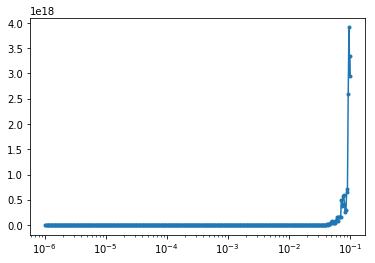

In [23]:
# backup = params.copy()

# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)

# params.update(backup)

# plt.semilogx(learning_rate, loss_validation, '.-')

## 2.2 Train Network

In [19]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 117 / 23521 (epoch 0.15 / 30):
  learning_rate = 1.91e-02, training loss = 1.65e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 50.53 (3170 / 6273), f1 (weighted): 44.34, loss: 2.02e+00
  CPU time: 45s, wall time: 50s
step 234 / 23521 (epoch 0.30 / 30):
  learning_rate = 1.82e-02, training loss = 1.72e+00
  validation accuracy: 56.56 (3548 / 6273), f1 (weighted): 52.58, loss: 1.74e+00
  CPU time: 85s, wall time: 95s
step 351 / 23521 (epoch 0.45 / 30):
  learning_rate = 1.74e-02, training loss = 2.02e+00
  validation accuracy: 58.31 (3658 / 6273), f1 (weighted): 56.99, loss: 1.62e+00
  CPU time: 123s, wall time: 139s
step 468 / 23521 (epoch 0.60 / 30):
  learning_rate = 1.66e-02, training loss = 1.82e+00
  validation accuracy: 59.92 (3759 / 6273), f1 (weighted): 57.83, loss: 1.57e+00
  CPU time: 162s, wall time: 183s
step 585 / 23521 (epoch 0.75 / 30):
  learning_rate = 1.58e-02, training loss = 1.63e+00
  validation accuracy: 60.58 (3800 / 6273), f1 (weighted): 58.55, loss: 1.48e+00
  CPU time: 201s, wall time: 227s
step 702 / 23521 (epoch 0.90 / 30):
  learning_rate = 1.51e-02, training 

  validation accuracy: 66.70 (4184 / 6273), f1 (weighted): 65.30, loss: 2.88e+00
  CPU time: 1576s, wall time: 1827s
step 4914 / 23521 (epoch 6.27 / 30):
  learning_rate = 2.80e-03, training loss = 2.91e-02
  validation accuracy: 66.91 (4197 / 6273), f1 (weighted): 65.39, loss: 2.60e+00
  CPU time: 1614s, wall time: 1871s
step 5031 / 23521 (epoch 6.42 / 30):
  learning_rate = 2.67e-03, training loss = 3.95e-02
  validation accuracy: 67.14 (4212 / 6273), f1 (weighted): 65.37, loss: 2.84e+00
  CPU time: 1652s, wall time: 1917s
step 5148 / 23521 (epoch 6.57 / 30):
  learning_rate = 2.55e-03, training loss = 4.06e-02
  validation accuracy: 67.26 (4219 / 6273), f1 (weighted): 65.52, loss: 2.79e+00
  CPU time: 1690s, wall time: 1963s
step 5265 / 23521 (epoch 6.72 / 30):
  learning_rate = 2.43e-03, training loss = 2.17e-02
  validation accuracy: 67.03 (4205 / 6273), f1 (weighted): 65.47, loss: 3.13e+00
  CPU time: 1728s, wall time: 2007s
step 5382 / 23521 (epoch 6.86 / 30):
  learning_rate = 

step 9477 / 23521 (epoch 12.09 / 30):
  learning_rate = 4.51e-04, training loss = 4.08e-04
  validation accuracy: 68.53 (4299 / 6273), f1 (weighted): 66.79, loss: 3.84e+00
  CPU time: 3082s, wall time: 3671s
step 9594 / 23521 (epoch 12.24 / 30):
  learning_rate = 4.30e-04, training loss = 1.86e-03
  validation accuracy: 68.74 (4312 / 6273), f1 (weighted): 66.96, loss: 3.81e+00
  CPU time: 3119s, wall time: 3718s
step 9711 / 23521 (epoch 12.39 / 30):
  learning_rate = 4.11e-04, training loss = 1.34e-03
  validation accuracy: 68.47 (4295 / 6273), f1 (weighted): 67.04, loss: 3.79e+00
  CPU time: 3156s, wall time: 3765s
step 9828 / 23521 (epoch 12.53 / 30):
  learning_rate = 3.92e-04, training loss = 1.28e-03
  validation accuracy: 68.69 (4309 / 6273), f1 (weighted): 67.14, loss: 3.77e+00
  CPU time: 3194s, wall time: 3813s
step 9945 / 23521 (epoch 12.68 / 30):
  learning_rate = 3.74e-04, training loss = 5.04e-05
  validation accuracy: 68.50 (4297 / 6273), f1 (weighted): 66.88, loss: 3.72e

  validation accuracy: 68.93 (4324 / 6273), f1 (weighted): 67.23, loss: 4.18e+00
  CPU time: 4556s, wall time: 5461s
step 14157 / 23521 (epoch 18.06 / 30):
  learning_rate = 6.93e-05, training loss = 1.83e-03
  validation accuracy: 69.07 (4333 / 6273), f1 (weighted): 67.50, loss: 4.14e+00
  CPU time: 4595s, wall time: 5506s
step 14274 / 23521 (epoch 18.21 / 30):
  learning_rate = 6.61e-05, training loss = 5.49e-04
  validation accuracy: 69.09 (4334 / 6273), f1 (weighted): 67.48, loss: 4.09e+00
  CPU time: 4633s, wall time: 5554s
step 14391 / 23521 (epoch 18.35 / 30):
  learning_rate = 6.31e-05, training loss = 2.57e-04
  validation accuracy: 69.12 (4336 / 6273), f1 (weighted): 67.43, loss: 4.04e+00
  CPU time: 4671s, wall time: 5599s
step 14508 / 23521 (epoch 18.50 / 30):
  learning_rate = 6.02e-05, training loss = 2.72e-04
  validation accuracy: 68.98 (4327 / 6273), f1 (weighted): 67.41, loss: 4.07e+00
  CPU time: 4709s, wall time: 5645s
step 14625 / 23521 (epoch 18.65 / 30):
  learni

step 18720 / 23521 (epoch 23.88 / 30):
  learning_rate = 1.12e-05, training loss = 1.31e-04
  validation accuracy: 69.36 (4351 / 6273), f1 (weighted): 67.73, loss: 4.11e+00
  CPU time: 6059s, wall time: 7319s
step 18837 / 23521 (epoch 24.02 / 30):
  learning_rate = 1.06e-05, training loss = 1.90e-05
  validation accuracy: 69.33 (4349 / 6273), f1 (weighted): 67.52, loss: 4.34e+00
  CPU time: 6097s, wall time: 7367s
step 18954 / 23521 (epoch 24.17 / 30):
  learning_rate = 1.02e-05, training loss = 6.49e-04
  validation accuracy: 68.93 (4324 / 6273), f1 (weighted): 67.34, loss: 4.00e+00
  CPU time: 6134s, wall time: 7411s
step 19071 / 23521 (epoch 24.32 / 30):
  learning_rate = 9.69e-06, training loss = 2.23e-04
  validation accuracy: 69.20 (4341 / 6273), f1 (weighted): 67.54, loss: 4.18e+00
  CPU time: 6171s, wall time: 7457s
step 19188 / 23521 (epoch 24.47 / 30):
  learning_rate = 9.25e-06, training loss = 6.32e-04
  validation accuracy: 69.20 (4341 / 6273), f1 (weighted): 67.47, loss: 

  validation accuracy: 69.09 (4334 / 6273), f1 (weighted): 67.62, loss: 4.06e+00
  CPU time: 7529s, wall time: 9127s
step 23400 / 23521 (epoch 29.84 / 30):
  learning_rate = 1.71e-06, training loss = 1.05e-04
  validation accuracy: 68.90 (4322 / 6273), f1 (weighted): 67.31, loss: 4.05e+00
  CPU time: 7566s, wall time: 9174s
step 23517 / 23521 (epoch 29.99 / 30):
  learning_rate = 1.64e-06, training loss = 1.13e-04
  validation accuracy: 69.03 (4330 / 6273), f1 (weighted): 67.42, loss: 4.20e+00
  CPU time: 7604s, wall time: 9224s
step 23521 / 23521 (epoch 30.00 / 30):
  learning_rate = 1.63e-06, training loss = 1.67e-04
  validation accuracy: 69.31 (4348 / 6273), f1 (weighted): 67.42, loss: 4.37e+00
  CPU time: 7616s, wall time: 9235s
validation accuracy: best = 69.57, mean = 69.05


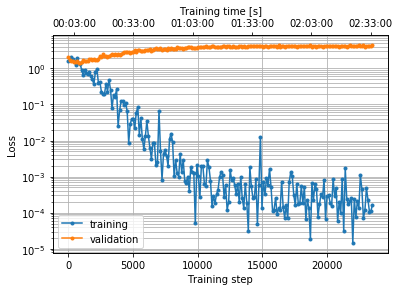

In [20]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

It seems that there is an overfit

In [16]:
predictions, loss = model.predict(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_32sides_0noise_CNN/model-7956


In [17]:
predictions-labels_val

array([-12.,   0.,  -9., ...,  49.,   5.,   2.])

In [18]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_32sides_0noise_CNN/model-7956


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 44.51 (2792 / 6273), f1 (weighted): 35.11, loss: 2.14e+00\nCPU time: 22s, wall time: 20s',
 44.508209787980235,
 35.113046915140785,
 2.136967680736647)

## test network

In [ ]:
val_dataset = shrecDataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=-1)

In [ ]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)
x_test, _, ids_test = test_dataset.return_data(train=False)

In [ ]:
predictions, loss = model.predict(x_val, labels_val)

In [ ]:
_, acc, f1, loss = model.evaluate(x_val, labels_val)

In [ ]:
predictions = model.predict(x_test)

write to file